In [35]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import torch
# from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Dataset, DataLoader
import torch.nn.functional as F

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem

In [2]:
df = pd.read_pickle('data/uspto50/uspto_50.pickle')
df

FileNotFoundError: [Errno 2] No such file or directory: 'data/uspto50/uspto_50.pickle'

In [ ]:
new_dataset = []

count = 0
for i, row in tqdm(df.iterrows(), total=len(df)):
    reactants = Chem.MolToSmiles(row['reactants_mol']).split('.')
    # product = Chem.MolToSmiles(row['products_mol'])
    product = row['products_mol']
    exclude_indices = list(range(count, count+len(reactants)))
    for reactant in reactants:
        reactant = Chem.MolFromSmiles(reactant)
        new_dataset.append([reactant, product, row['reaction_type'], row['set'], exclude_indices])
    count += len(reactants)

new_dataset

In [ ]:
# save new_dataset as a pandas dataframe
retrieval_df = pd.DataFrame(new_dataset, columns=['reactants_mol', 'products_mol', 'reaction_type', 'set', 'exclude_indices'])
retrieval_df.to_pickle('data/uspto50/uspto_50_retrieval.pickle')

retrieval_df

In [4]:
# load the dataset directly if saved before
retrieval_df = pd.read_pickle('uspto_50_retrieval.pickle')
retrieval_df

,reactants_mol,products_mol,reaction_type,set,exclude_indices
0,<rdkit.Chem.rdchem.Mol object at 0x7ff8c8c5c680>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57ebfb0>,<RX_1>,train,"[0, 1]"
1,<rdkit.Chem.rdchem.Mol object at 0x7ff8c8c5c6d0>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57ebfb0>,<RX_1>,train,"[0, 1]"
2,<rdkit.Chem.rdchem.Mol object at 0x7ff8c8c5ca40>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57bc040>,<RX_6>,train,[2]
3,<rdkit.Chem.rdchem.Mol object at 0x7ff8c8c5c810>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c5804090>,<RX_9>,train,"[3, 4]"
4,<rdkit.Chem.rdchem.Mol object at 0x7ff8c8c5c900>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c5804090>,<RX_9>,train,"[3, 4]"
...,...,...,...,...,...
85533,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57ebe20>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c35210d0>,<RX_7>,test,[85533]
85534,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57ebe70>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c3369120>,<RX_10>,test,"[85534, 85535]"
85535,<rdkit.Chem.rdchem.Mol object at 0x7ff8c57ebec0>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c3369120>,<RX_10>,test,"[85534, 85535]"
85536,<rdkit.Chem.rdchem.Mol object at 0x7ff8c578bf10>,<rdkit.Chem.rdchem.Mol object at 0x7ff8c33c1170>,<RX_1>,test,"[85536, 85537]"


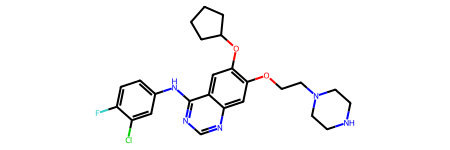

In [5]:
mol = retrieval_df.iloc[1]['reactants_mol']
# mol.GetNumAtoms(), mol.GetNumBonds()
mol

In [6]:
ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [
    BT.SINGLE, 
    BT.DOUBLE, 
    BT.TRIPLE, 
    BT.AROMATIC
]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]

In [7]:
class USPTO50_graph(Dataset):
    def __init__(self, df, split: str='train'):
        super(USPTO50_graph, self).__init__()
        self.df = df[df['set']==split]

    def create_graph(self, mol):
        N = mol.GetNumAtoms()
        M = mol.GetNumBonds()

        type_idx = []
        chirality_idx = []
        atomic_number = []
        # aromatic = []
        # sp, sp2, sp3, sp3d = [], [], [], []
        # num_hs = []
        for atom in mol.GetAtoms():
            type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
            chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
            atomic_number.append(atom.GetAtomicNum())
            # aromatic.append(1 if atom.GetIsAromatic() else 0)
            # hybridization = atom.GetHybridization()
            # sp.append(1 if hybridization == HybridizationType.SP else 0)
            # sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
            # sp3.append(1 if hybridization == HybridizationType.SP3 else 0)
            # sp3d.append(1 if hybridization == HybridizationType.SP3D else 0)

        # z = torch.tensor(atomic_number, dtype=torch.long)
        x1 = torch.tensor(type_idx, dtype=torch.long).view(-1,1)
        x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1,1)
        x = torch.cat([x1, x2], dim=-1)
        # x2 = torch.tensor([atomic_number, aromatic, sp, sp2, sp3, sp3d, num_hs],
        #                     dtype=torch.float).t().contiguous()
        # x = torch.cat([x1.to(torch.float), x2], dim=-1)

        row, col, edge_feat = [], [], []
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            row += [start, end]
            col += [end, start]
            # edge_type += 2 * [MOL_BONDS[bond.GetBondType()]]
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])
            edge_feat.append([
                BOND_LIST.index(bond.GetBondType()),
                BONDDIR_LIST.index(bond.GetBondDir())
            ])

        edge_index = torch.tensor([row, col], dtype=torch.long)
        edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)

        # edge_index --> graph connectivity
        # edge_attr --> edge features
        # x --> node features

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        return data
    
    def get(self, index):
        reactant, product, reaction_type, _set, exclude_indices = self.df.iloc[index]
        
        anchor = product
        positive_sample = reactant
        
        # randomly pick negative sample from the dataset apart from the exluded indices
        # negative_sample_index = np.random.choice(list(set(range(len(self.df))) - set(exclude_indices)))
        negative_sample_index = random.choice([i for i in range(self.len()) if i not in exclude_indices])
        negative_sample = self.df.iloc[negative_sample_index]['reactants_mol']

        # create graph for all three molecules
        anchor_data = self.create_graph(anchor) # this is a tuple of edge_index, edge_attr, x
        positive_sample_data = self.create_graph(positive_sample)
        negative_sample_data = self.create_graph(negative_sample)

        data = Data(anchor=anchor_data, positive_sample=positive_sample_data, negative_sample=negative_sample_data)
        
        return data
        # return anchor, positive_sample, negative_sample # returns the graphs for all three molecules
    
    def len(self):
        return len(self.df)

In [43]:
retrieval_df = pd.read_pickle('uspto_50_retrieval.pickle')

uspto_graph_retrieval_dataset = USPTO50_graph(retrieval_df, split='train')

data = uspto_graph_retrieval_dataset[0]
anchor = data.anchor
positive_sample = data.positive_sample
negative_sample = data.negative_sample

anchor, positive_sample, negative_sample

(Data(x=[41, 2], edge_index=[2, 92], edge_attr=[92, 2]),
 Data(x=[12, 2], edge_index=[2, 24], edge_attr=[24, 2]),
 Data(x=[24, 2], edge_index=[2, 54], edge_attr=[54, 2]))

In [ ]:
train_dataloader = DataLoader(USPTO50_graph(retrieval_df, split='train'), batch_size=32, shuffle=True, num_workers=4)
# val_dataloader = DataLoader(USPTO50_graph(retrieval_df, split='valid'), batch_size=32, shuffle=False, num_workers=4)
# test_dataloader = DataLoader(USPTO50_graph(retrieval_df, split='test'), batch_size=32, shuffle=False, num_workers=4)

In [58]:
from gcn_finetune import GCN

In [59]:
gcn_model = GCN(feat_dim=512)
state_dict = torch.load('ckpt/pretrainted_gcn_ckpt/model.pth')
gcn_model.load_my_state_dict(state_dict)

# h = gcn_model(anchor)
# h, h.shape

In [63]:
h1 = gcn_model.forward(anchor)
h2 = gcn_model.forward(positive_sample)
h3 = gcn_model.forward(negative_sample)

cos1 = F.cosine_similarity(h1, h2)
cos2 = F.cosine_similarity(h1, h3)

euc1 = torch.norm(h1 - h2, dim=-1)
euc2 = torch.norm(h1 - h3, dim=-1)

cos1.item(), cos2.item(), euc1.item(), euc2.item()

(1.0000001192092896, 1.0, 5.378654805099359e-06, 2.967915179397096e-06)

In [61]:
F.cosine_similarity(gcn_model.forward(uspto_graph_retrieval_dataset[0].anchor), gcn_model.forward(uspto_graph_retrieval_dataset[100].negative_sample)).item()

1.0